**Table of contents**<a id='toc0_'></a>    
- 1. [Count earthquakes around tremor in Nankai    ](#toc1_)    
- 2. [Load data   ](#toc2_)    
  - 2.1. [Load earthquake catalog   ](#toc2_1_)    
  - 2.2. [Load tremor catalog   ](#toc2_2_)    
  - 2.3. [Count number of earthquakes at triggering distance  ](#toc2_3_)    
    - 2.3.1. [Compute number of earthquakes at triggering distance ](#toc2_3_1_)    
    - 2.3.2. [Triggering distance defined as a function of magnitude](#toc2_3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Count earthquakes around tremor in Nankai     [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

In [2]:
# Geographic distance
def distance(lon1, lat1, z1, lon2, lat2, z2):
    # Convert degrees to radians
    lon1_rad = np.radians(lon1)
    lat1_rad = np.radians(lat1)
    lon2_rad = np.radians(lon2)
    lat2_rad = np.radians(lat2)

    # Compute differences in longitude and latitude
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance_km = 6371 * c

    distance_km = np.sqrt(distance_km**2 + (z2 - z1)**2)

    return distance_km

# 2. <a id='toc2_'></a>Load data    [&#128285;](#toc0_)

## 2.1. <a id='toc2_1_'></a>Load earthquake catalog    [&#128285;](#toc0_)

In [19]:
# Directly load catalog from csv
eq = pd.read_csv(workdir + 'projects/data/Catalogs/JMA/eq_2000_2021.csv', parse_dates=['date'])
print('{:d} events in the catalog'.format(len(eq)))

3801905 events in the catalog


## 2.2. <a id='toc2_2_'></a>Load tremor catalog    [&#128285;](#toc0_)

In [4]:
# Load data
path = workdir + 'projects/data/Catalogs/world_tremor_database/nankai_wtb_0413.csv'

COLS = ['date', 'time', 'lat', 'lon', 'depth', 'mag', 'dur', 'err', 'optional_date']
trm = pd.read_csv(
    path,
    names=COLS,
)

trm['date_str'] = trm.date.values + ' ' + trm.time.values
trm['date'] = pd.to_datetime(trm.date_str)
day0 = np.datetime64('2004-01-01')
trm['day'] = (trm.date - day0) / np.timedelta64(1, 'D')

trm.sort_values(by=["date"], inplace=True)
print('{:d} tremor detections, spanning {:d}--{:d}'.format(trm.shape[0], trm.date.min().year, trm.date.max().year))

82275 tremor detections, spanning 2004--2013


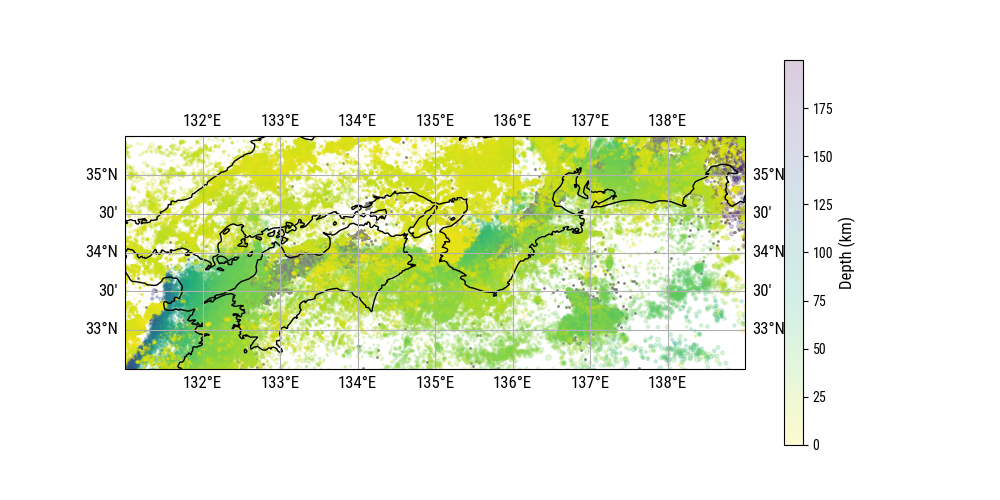

In [32]:
# Plot it
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([131, 139, 32.5, 35.5], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black')

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.scatter(trm.lon, trm.lat, s=1, c='.5', transform=ccrs.PlateCarree())
sc = ax.scatter(eq.lon[eq.depth<200], eq.lat[eq.depth<200], s=eq.mag[eq.depth<200]**2, c=eq.depth[eq.depth<200], transform=ccrs.PlateCarree(), alpha=.2, cmap='viridis_r')
plt.colorbar(sc, label='Depth (km)')


plt.show()

## 2.3. <a id='toc2_3_'></a>Count number of earthquakes at triggering distance   [&#128285;](#toc0_)
Could improve:
- Count all earthquakes of the period instead of the ones during the 10 years of the catalog?

In [67]:
compute = True

In [88]:
# Which earthquakes should count
interval = [np.datetime64('2004-01-01'), np.datetime64('2013-04-01')]

min_mag = 1.5  # Mc~1.5

selected_eq = eq[(eq.date.values >= interval[0]) & (eq.date.values <= interval[1]) & (eq.mag >= min_mag)]
print('{:} selected earthquakes'.format(np.shape(selected_eq)[0]))

498407 selected earthquakes


### 2.3.1. <a id='toc2_3_1_'></a>Compute number of earthquakes at triggering distance  [&#128285;](#toc0_)


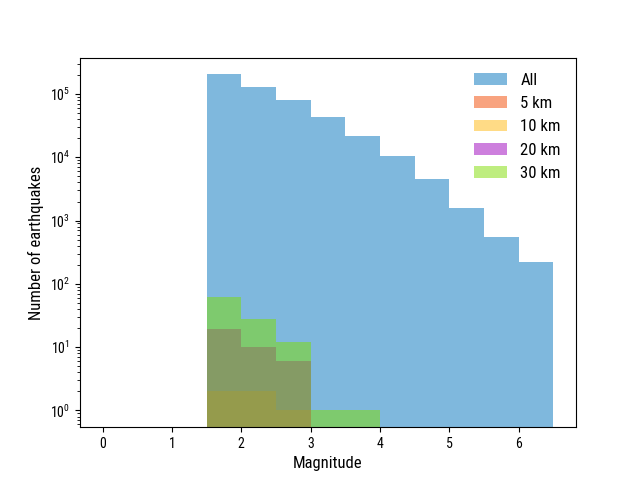

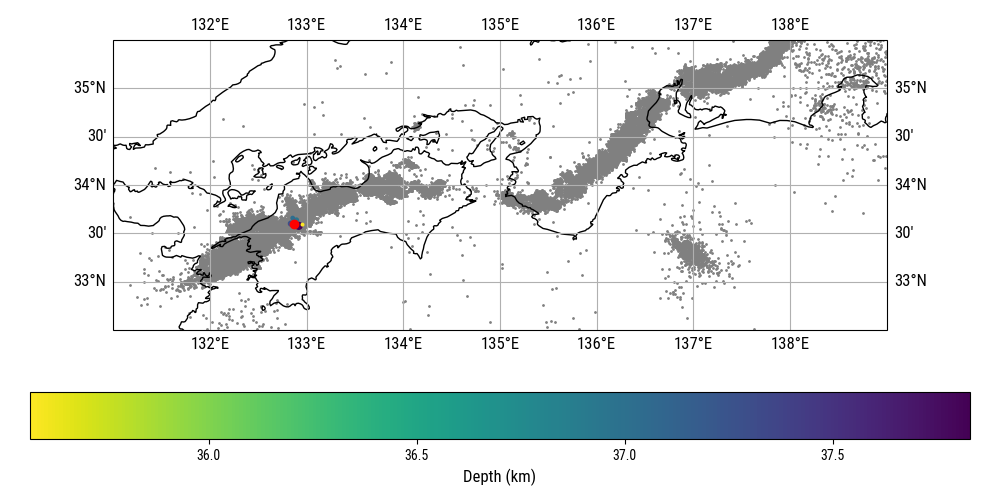

In [89]:
# For one tremor
tremor = trm.iloc[2]
distances = distance(selected_eq.lon.values, selected_eq.lat.values, selected_eq.depth.values, tremor.lon, tremor.lat, tremor.depth)

eq_5km = distances < 5
eq_10km = distances < 10
eq_20km = distances < 20
eq_30km = distances < 30

fig, ax = plt.subplots()
ax.set_xlabel('Magnitude')
ax.set_ylabel('Number of earthquakes')
ax.hist(selected_eq.mag, bins=np.arange(0, 7, .5), alpha=.5, label='All')
ax.hist(selected_eq.mag[eq_5km], bins=np.arange(0, 7, .5), alpha=.5, label='5 km')
ax.hist(selected_eq.mag[eq_10km], bins=np.arange(0, 7, .5), alpha=.5, label='10 km')
ax.hist(selected_eq.mag[eq_20km], bins=np.arange(0, 7, .5), alpha=.5, label='20 km')
ax.hist(selected_eq.mag[eq_30km], bins=np.arange(0, 7, .5), alpha=.5, label='30 km')
ax.legend()
ax.set_yscale('log')
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([131, 139, 32.5, 35.5], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black')

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.scatter(trm.lon, trm.lat, s=1, c='.5', transform=ccrs.PlateCarree())
ax.plot(tremor.lon, tremor.lat, 'ro', transform=ccrs.PlateCarree())

indicator = eq_10km

sc = ax.scatter(selected_eq.lon[indicator], selected_eq.lat[indicator], s=selected_eq.mag[indicator]**3, c=selected_eq.depth[indicator], transform=ccrs.PlateCarree(), alpha=1, cmap='viridis_r')
plt.colorbar(sc, label='Depth (km)', orientation='horizontal')

plt.tight_layout()
plt.show()

In [93]:
# Compute number of earthquakes at stressing distance for each tremor
if compute:
    n_5km = np.zeros(trm.shape[0])
    n_10km = np.zeros(trm.shape[0])
    n_20km = np.zeros(trm.shape[0])
    n_30km = np.zeros(trm.shape[0])

    eq_5km = np.zeros(selected_eq.shape[0], dtype=bool)
    eq_10km = np.zeros(selected_eq.shape[0], dtype=bool)
    eq_20km = np.zeros(selected_eq.shape[0], dtype=bool)
    eq_30km = np.zeros(selected_eq.shape[0], dtype=bool)

    subset_size = 10  # Number of tremors to process at once
    ii = 0
    while ii < trm.shape[0]:
        print(f'Tremor sample {ii}/{trm.shape[0]}', end='\r')
        # Subset
        lons = trm.lon.values[ii:ii+subset_size]
        lats = trm.lat.values[ii:ii+subset_size]
        depths = trm.depth.values[ii:ii+subset_size]

        # Compute distances (dim (subset_size, n_eq))
        distances = distance(lats[:, np.newaxis], lons[:, np.newaxis], depths[:, np.newaxis], selected_eq.lat.values, selected_eq.lon.values, selected_eq.depth.values)
        dist5 = distances < 5.
        dist10 = distances < 10.
        dist20 = distances < 20.
        dist30 = distances < 30.

        # Count number of earthqakes (dim (subset_size, ))
        n_5km[ii:ii+subset_size] = dist5.sum(axis=1)
        n_10km[ii:ii+subset_size] = dist10.sum(axis=1)
        n_20km[ii:ii+subset_size] = dist20.sum(axis=1)
        n_30km[ii:ii+subset_size] = dist30.sum(axis=1)

        # Select earthquakes
        eq_5km = dist5.any(axis=0) | eq_5km
        eq_10km = dist10.any(axis=0) | eq_10km
        eq_20km = dist20.any(axis=0) | eq_20km
        eq_30km = dist30.any(axis=0) | eq_30km

        # Update ii
        ii = ii + subset_size

In [105]:
# Save it
if compute:
    print('Saving it...')
    trm['n_5km'] = n_5km
    trm['n_10km'] = n_10km
    trm['n_20km'] = n_20km
    trm['n_30km'] = n_30km

    trm.to_csv('data/nankai/processed/nank_trm_0104_0413_dist.csv', index=False)

    selected_eq['eq_5km'] = eq_5km
    selected_eq['eq_10km'] = eq_10km
    selected_eq['eq_20km'] = eq_20km
    selected_eq['eq_30km'] = eq_30km

    selected_eq.to_csv('data/nankai/processed/nank_eqmc{:.1f}_0104_0413_dist.csv'.format(min_mag), index=False)

Saving it...


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_34266/654564819.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_eq['eq_5km'] = eq_5km
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_34266/654564819.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_eq['eq_10km'] = eq_10km
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_34266/654564819.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [96]:
# Load it
if not compute:
    trm = pd.read_csv('data/nankai/processed/nank_trm_0104_0413_dist.csv')
    trm['date'] = pd.to_datetime(trm.date)

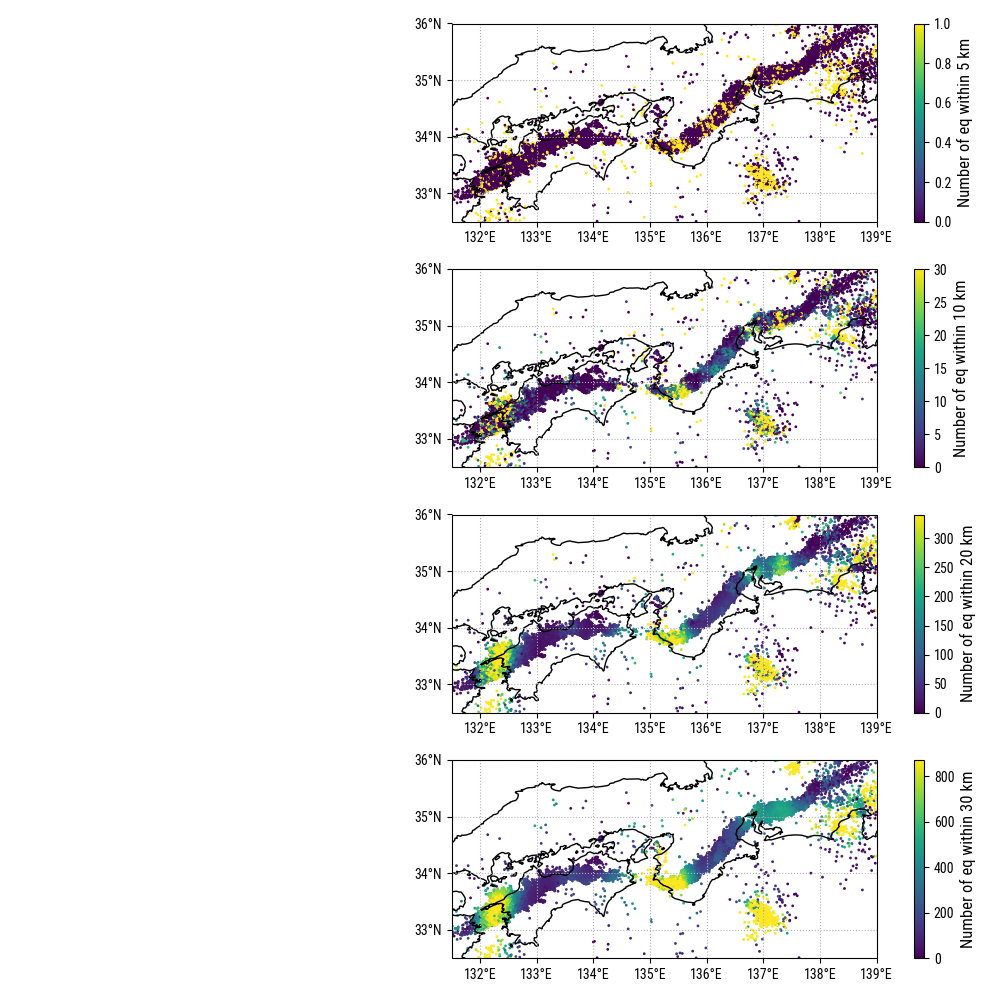

In [104]:
# Show it
fig = plt.figure(figsize=(10, 10))
axes = [fig.add_subplot(4, 1, ii+1, projection=ccrs.PlateCarree()) for ii in range(4)]

for d, ax in zip([5, 10, 20, 30], axes):
    ax.coastlines()

    sc = ax.scatter(trm.lon, trm.lat, s=1, c=trm['n_{:d}km'.format(d)], transform=ccrs.PlateCarree(), vmin=0, vmax=np.percentile(trm['n_{:d}km'.format(d)], 90))
    plt.colorbar(sc, label='Number of eq within {:d} km'.format(d), ax=ax, orientation='vertical', pad=0.04, fraction=0.046)

    ax.grid('on', ls=':', zorder=-1)
    ax.set_xticks(np.arange(131, 140, 1), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(32, 37, 1), crs=ccrs.PlateCarree())
    ax.set_extent([131.5, 139, 32.5, 36])
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

plt.tight_layout()
plt.show()

### 2.3.2. <a id='toc2_3_2_'></a>Triggering distance defined as a function of magnitude [&#128285;](#toc0_)

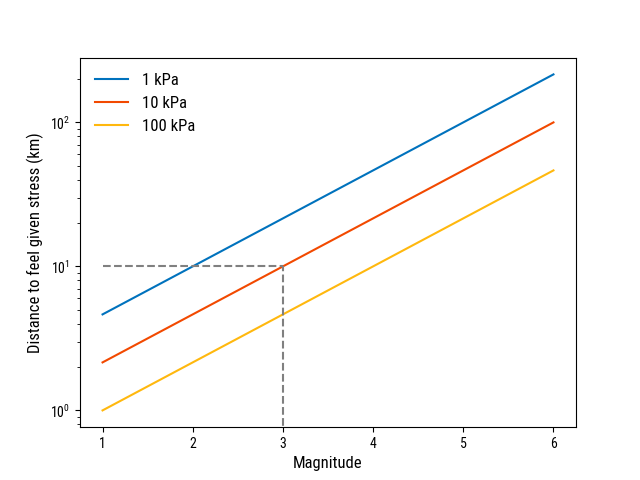

In [61]:
# Distance for a given stress function
ref_mag = 3
ref_dist = 10  # km
ref_stress = 10  # kPa
alpha = 3  # exponent of the for the distance dependence
C = ref_stress * ref_dist**alpha * 10**(-ref_mag)

def dist_stress(mag, stress):
    return (C / stress * 10**(mag))**(1/alpha)

# Show what it looks like
mags = np.linspace(1, 6, 100)
stresses = [1, 10, 100]

fig, ax = plt.subplots()
ax.set_xlabel('Magnitude')
ax.set_ylabel('Distance to feel given stress (km)')
ax.set_yscale('log')
for stress in stresses:
    ax.plot(mags, dist_stress(mags, stress), label=f'{stress} kPa')
ax.legend()

ax.plot([mags.min(), ref_mag], [ref_dist, ref_dist], linestyle='--', c='.5')
ax.plot([ref_mag, ref_mag], [0, ref_dist], linestyle='--', c='.5')

plt.show()

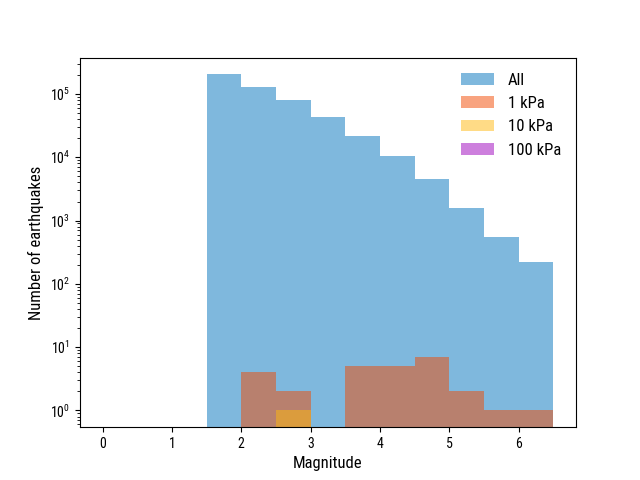

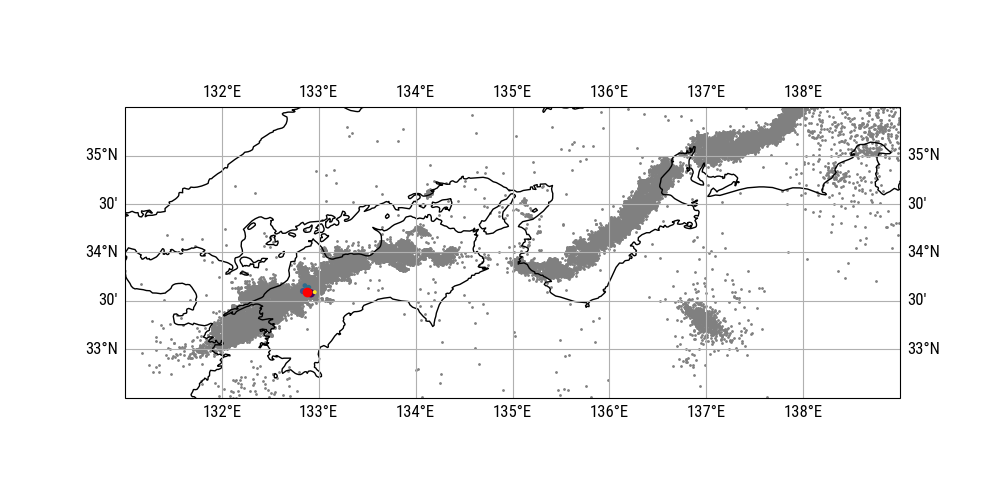

In [66]:
# For one tremor
tremor = trm.iloc[2]
distances = distance(selected_eq.lon.values, selected_eq.lat.values, selected_eq.depth.values, tremor.lon, tremor.lat, tremor.depth)

eq_1kPa = distances < dist_stress(selected_eq.mag.values, 1)
eq_10kPa = distances < dist_stress(selected_eq.mag.values, 10)
eq_100kPa = distances < dist_stress(selected_eq.mag.values, 100)

eq_close = distances < 10

fig, ax = plt.subplots()
ax.set_xlabel('Magnitude')
ax.set_ylabel('Number of earthquakes')
ax.hist(selected_eq.mag, bins=np.arange(0, 7, .5), alpha=.5, label='All')
ax.hist(selected_eq.mag[eq_1kPa], bins=np.arange(0, 7, .5), alpha=.5, label='1 kPa')
ax.hist(selected_eq.mag[eq_10kPa], bins=np.arange(0, 7, .5), alpha=.5, label='10 kPa')
ax.hist(selected_eq.mag[eq_100kPa], bins=np.arange(0, 7, .5), alpha=.5, label='100 kPa')
ax.legend()
ax.set_yscale('log')
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([131, 139, 32.5, 35.5], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black')

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.scatter(trm.lon, trm.lat, s=1, c='.5', transform=ccrs.PlateCarree())
ax.plot(tremor.lon, tremor.lat, 'ro', transform=ccrs.PlateCarree())
sc = ax.scatter(selected_eq.lon[eq_close], selected_eq.lat[eq_close], s=selected_eq.mag[eq_close]**3, c=selected_eq.depth[eq_close], transform=ccrs.PlateCarree(), alpha=1, cmap='viridis_r')


plt.show()

In [11]:
# # Compute number of earthquakes at stressing distance for each tremor
# if compute:
#     n_1kPa = np.zeros(trm.shape[0])
#     n_10kPa = np.zeros(trm.shape[0])
#     n_100kPa = np.zeros(trm.shape[0])

#     subset_size = 20  # Number of tremors to process at once
#     ii = 0
#     while ii < trm.shape[0]:
#         print(f'Tremor sample {ii}/{trm.shape[0]}', end='\r')
#         # Subset
#         lons = trm.lon.values[ii:ii+subset_size]
#         lats = trm.lat.values[ii:ii+subset_size]
#         depths = trm.depth.values[ii:ii+subset_size]

#         # Compute distances (dim (subset_size, n_eq))
#         distances = distance(lats[:, np.newaxis], lons[:, np.newaxis], depths[:, np.newaxis], selected_eq.lat.values, selected_eq.lon.values, selected_eq.depth.values)

#         # Count number of earthqakes (dim (subset_size, ))
#         n_1kPa[ii:ii+subset_size] = (distances < dist_stress(selected_eq.mag.values, 1)).sum(axis=1)
#         n_10kPa[ii:ii+subset_size] = (distances < dist_stress(selected_eq.mag.values, 10)).sum(axis=1)
#         n_100kPa[ii:ii+subset_size] = (distances < dist_stress(selected_eq.mag.values, 100)).sum(axis=1)

#         # Update ii
#         ii = ii + subset_size

In [75]:
# # Save it
# if compute:
#     print('Saving it...')
#     trm['n_1kPa'] = n_1kPa
#     trm['n_10kPa'] = n_10kPa
#     trm['n_100kPa'] = n_100kPa

#     trm.to_csv('data/nankai/processed/nank_trm_0104_0413_stress.csv', index=False)

In [76]:
# # Load it
# if not compute:
#     print('Loading it...')
#     trm = pd.read_csv('data/nankai/processed/nank_trm_0104_0413_stress.csv')
#     trm['date'] = pd.to_datetime(trm.date)